In [1]:
# Check along-fjord properties in wind-forcing runs
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import cmocean
import Functions as fun
import os, sys
#sys.path.append(os.path.abspath('/work/oceans/wbao/MITgcm_results/jorgemontt'))

In [2]:
# Input file info
#path1 = '/work/oceans/wbao/MITgcm_results/jorgemontt/Qsg150_wind'
path1 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind/'
path2 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_rep_wind/'

taum1 = np.array([-0.2, -0.1, 0, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8, -1.5, 1.5]) # maximum wind stress (single event)
taum2 = np.array([-0.2, -0.1, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8]) # maximum wind stress (repeated events)

xrange = np.array([0,97]) # X index range for the segment between glacier and outer sill
xsill = 95

# Indexes for down-/up-fjord wind
down_case1 = [3,4,5,8,9,11,13]
up_case1 = [2,1,6,7,10,12]

down_case2 = [3,4,7,8,10]
up_case2 = [2,1,5,6,9]

## Wind Forcing

In [3]:
# Zonal Wind Stress
externForcingCircle = 30*86400 # Forcing period in second
externForcingPeriod = 0.25*86400 # time interval between forcing field records
nt = int(externForcingCircle / externForcingPeriod)
model_time = np.linspace(0,externForcingCircle,nt+1);
up = 0*86400 / externForcingPeriod
down = 2.5*86400 / externForcingPeriod
ramp = 0.5*86400 / externForcingPeriod
taum = taum1.copy() # maximum wind stress

zonal_wind_stress = np.zeros((len(taum),nt))

nf = int(down+ramp)
forcing = np.zeros((len(taum),nf))

for i in range(0,len(taum)):
    tau = taum[i]
    for j in range(nf):
        if j <= up - 1:
            forcing[i, j] = 0
        elif j < up + ramp - 1:
            forcing[i, j] = tau * (j - (up - 1)) / ramp
        elif j > down-1:
            forcing[i, j] = tau * (down + ramp - 1 - j) / ramp
        else:
            forcing[i, j] = tau

zonal_wind_stress[:,:nf] = forcing

rt = 1 # number of repeated wind events

zonal_wind_stress[:,:nf*rt] = np.tile(forcing, rt)

wind = np.concatenate((np.zeros((len(taum),1)), zonal_wind_stress), axis=1)

## Along-Fjord Properties
* `dist`: along-fjord distance [km]
* `depth`: meters
* `time`: seconds
* `temp`: potential temperature
* `sal`: salinity
* `den`: density
* `u`: along-fjord velocity
* `w`: vertical velocity

In [4]:
# No-wind case
dist, depth, time, temp0, sal0, den0, u0, w0 = fun.along_fjord_state(path1,3)

In [85]:
# Single wind event
# tau_max = np.array([-0.2, -0.1, 0, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8, -1.5, 1.5])
caseN = 4
print("Maximum zonal wind stress: {} N/m^2".format(taum1[caseN-1]))
dist, depth, time, temp, sal, den, u, w = fun.along_fjord_state(path1,caseN)

Maximum zonal wind stress: 0.1 N/m^2


## Time-mean along-fjord

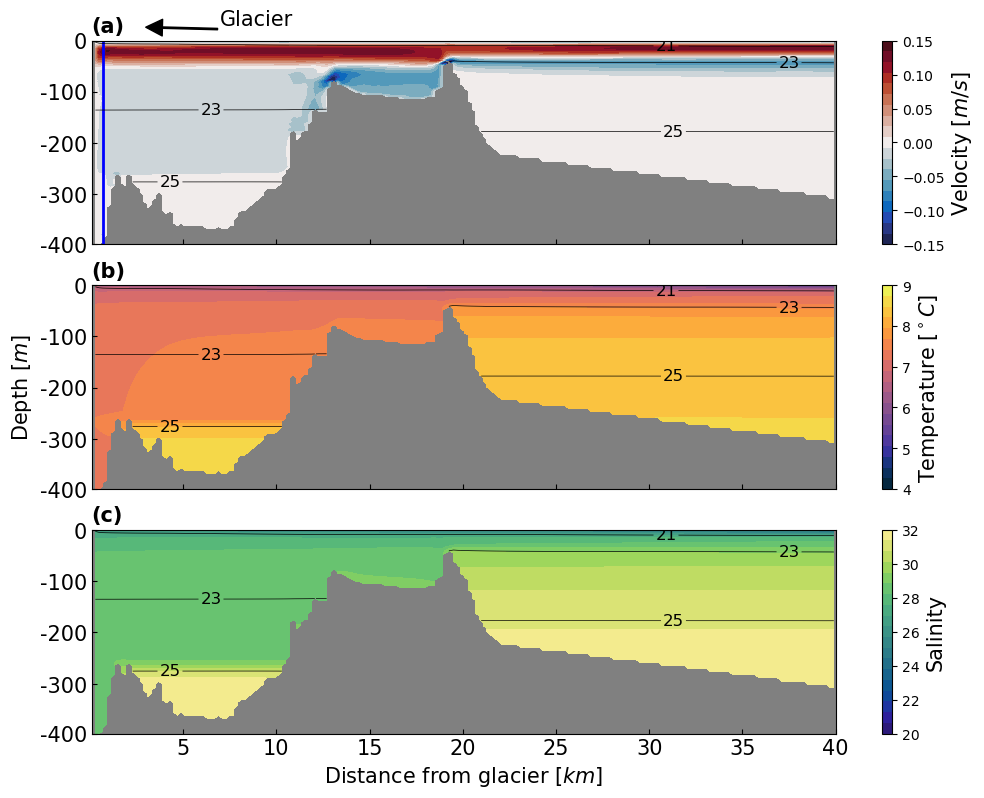

In [35]:

# Plot along-fjord velocity, temperature, and salinity
fig1, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(12,9))



# Time-mean (60~90d)
U, Temp, Sal, RhoA = u0.mean(0), temp0.mean(0), sal0.mean(0), den0.mean(0)-1000
pt0 = temp0[0,:,:]
mask = (pt0 == 0)
U[mask] = np.nan
Temp[mask] = np.nan
Sal[mask] = np.nan
RhoA[mask] = np.nan

cr_u = np.linspace(-0.15,0.15,20) # Contour range
cr_t = np.linspace(4,9,20)
cr_s = np.linspace(20,32,20)
cr_rho = np.linspace(1017,1027,6)-1000

# Along-fjord velocity
im1 = ax1.contourf(dist, depth, U, cr_u, cmap=cmocean.cm.balance) 
ax1.axvline(x=dist[3], color='b',lw=2)
#ax1.axhline(y=-50, color='b',lw=2)
CS1 = ax1.contour(dist, depth,RhoA,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS1, fontsize=12, inline=1)

cbar1 = fig1.colorbar(im1,ax=ax1)
#cbar1.set_ticks([-0.1,-0.05,0,0.05,0.1])
cbar1.set_ticks([-0.15, -0.1,-0.05,0,0.05,0.1,0.15])
cbar1.set_label('Velocity [$m/s$]', size=15)

ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=15)
#ax1.xaxis.set_visible(False)
ax1.set_xlim([dist[0],40])
# ax1.set_xticks([X[0], 10, 20, 30, X[-1]])
ax1.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax1.set_yticklabels(["0","-100","-200","-300","-400"])
#ax1.set_ylabel('Depth [$m$]', size=15)
ax1.set_title(r'(a)', loc='left', size=15, weight='bold')

ax1.annotate('Glacier', xy=(3,25), xytext=(7,29), 
            xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=15, annotation_clip=False)


# Potential temperature
im2 = ax2.contourf(dist, depth, Temp, cr_t, cmap=cmocean.cm.thermal) 
#ax2.axvline(x=x_dist[120], color='g',lw=2)
CS2 = ax2.contour(dist, depth,RhoA,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS2, fontsize=12, inline=1)

cbar2 = fig1.colorbar(im2,ax=ax2)
cbar2.set_ticks([4,5,6,7,8,9])
cbar2.set_label('Temperature [$^\circ C$]', size=15)

ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=15)
ax2.set_xlim([dist[0],40])
#ax2.set_xticks([X[0], 10, 20, 30, X[-1]])
ax2.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_ylabel('Depth [$m$]', size=15)
ax2.set_title(r'(b)', loc='left', size=15, weight='bold')



# Salinity
im3 = ax3.contourf(dist, depth, Sal, cr_s, cmap=cmocean.cm.haline)
#ax1.axvline(x=x_dist[120], color='g',lw=2)
CS3 = ax3.contour(dist, depth,RhoA,cr_rho, colors='k', linewidths=.5)
plt.clabel(CS3, fontsize=12, inline=1)

cbar3 = fig1.colorbar(im3,ax=ax3)
cbar3.set_ticks([20,22,24,26,28,30,32])
cbar3.set_label('Salinity', size=15)


ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=15)
ax3.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax3.set_yticklabels(["0","-100","-200","-300","-400"])
#ax3.set_ylabel('Depth [$m$]', size=15)
ax3.set_title(r'(c)', loc='left', size=15, weight='bold')
ax3.set_xlim([dist[0],40])
#ax3.set_xticks([X[0], 10, 20, 30, X[-1]])
#ax3.set_xticklabels(["0","10","20","30","40"])
ax3.set_xlabel('Distance from glacier [$km$]', size=15)

fig1.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/along-fjord_nowind.png', dpi=300, bbox_inches='tight')

## Divergence with no-wind case

In [9]:
np.nanmax(Udiv),np.nanmin(Udiv), np.nanmax(Tdiv),np.nanmin(Tdiv), np.nanmax(Sdiv),np.nanmin(Sdiv)

(0.07092203, -0.041997813, 0.32949066, -0.500721, 0.69317436, -1.3933697)

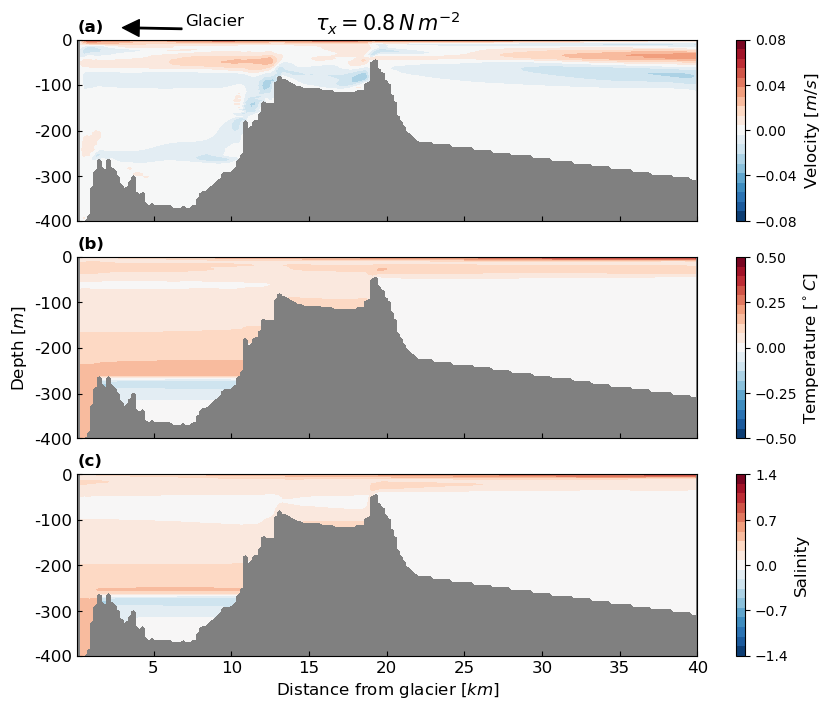

In [33]:

# Along-fjord velocity, temperature, and salinity
fig1d, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(10,8))


# Time-mean (60~90d)
Udiv = u.mean(0)-u0.mean(0)
Tdiv = temp.mean(0)-temp0.mean(0)
Sdiv = sal.mean(0)-sal0.mean(0)
pt0 = temp0[0,:,:]
mask = (pt0 == 0)
Udiv[mask] = np.nan
Tdiv[mask] = np.nan
Sdiv[mask] = np.nan

cr_u = np.linspace(-0.08,0.08,20) # Contour range
cr_t = np.linspace(-0.5,0.5,20)
cr_s = np.linspace(-1.4,1.4,20)

# Along-fjord velocity
im1 = ax1.contourf(dist, depth, Udiv, cr_u, cmap='RdBu_r') 

cbar1 = fig1d.colorbar(im1,ax=ax1)
cbar1.set_ticks([-0.08,-0.04,0,0.04,0.08])
cbar1.set_label('Velocity [$m/s$]', size=12)

ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=12)
#ax1.xaxis.set_visible(False)
ax1.set_xlim([dist[0],40])
# ax1.set_xticks([X[0], 10, 20, 30, X[-1]])
ax1.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax1.set_yticklabels(["0","-100","-200","-300","-400"])
ax1.set_title(r'(a)', loc='left', size=12, weight='bold')
ax1.set_title(r'$\tau_x=0.8\,N\,m^{-2}$', loc='center', size=15)
ax1.annotate('Glacier', xy=(3,25), xytext=(7,29), 
            xycoords='data', arrowprops=dict(facecolor='black',width=1), fontsize=12, annotation_clip=False)


# Potential temperature
im2 = ax2.contourf(dist, depth, Tdiv, cr_t, cmap='RdBu_r') 

cbar2 = fig1d.colorbar(im2,ax=ax2)
cbar2.set_ticks([-0.5,-0.25,0,0.25,0.5])
cbar2.set_label('Temperature [$^\circ C$]', size=12)

ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=12)
ax2.set_xlim([dist[0],40])
#ax2.set_xticks([X[0], 10, 20, 30, X[-1]])
ax2.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_ylabel('Depth [$m$]', size=12)
ax2.set_title(r'(b)', loc='left', size=12, weight='bold')



# Salinity
im3 = ax3.contourf(dist, depth, Sdiv, cr_s, cmap='RdBu_r')

cbar3 = fig1d.colorbar(im3,ax=ax3)
cbar3.set_ticks([-1.4,-0.7,0,0.7,1.4])
cbar3.set_label('Salinity', size=12)


ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=12)
ax3.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax3.set_yticklabels(["0","-100","-200","-300","-400"])
#ax3.set_ylabel('Depth [$m$]', size=15)
ax3.set_title(r'(c)', loc='left', size=12, weight='bold')
ax3.set_xlim([dist[0],40])
#ax3.set_xticks([X[0], 10, 20, 30, X[-1]])
#ax3.set_xticklabels(["0","10","20","30","40"])
ax3.set_xlabel('Distance from glacier [$km$]', size=12)

fig1d.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/along-fjord_Div11.png', dpi=300, bbox_inches='tight')

## Time evolution at a section

In [86]:
# Near-glacier stratification
xng = 3
pres = gsw.p_from_z(depth, -48.25)    
Nsq, Pmid = gsw.Nsquared(sal[:,:,xng],temp[:,:,xng],pres,-48.25,axis=1)
Nsq[Nsq<0] = 0

# No-wind case
Nsq0, Pmid0 = gsw.Nsquared(sal0[:,:,xng],temp0[:,:,xng],pres,-48.25,axis=1)
Nsq0[Nsq0<0] = 0

In [56]:
Nsq0.mean(),Nsq0.max(), Nsq.mean(),Nsq.max()

(8.06831710307932e-05,
 0.0012428399601029632,
 9.448110937415026e-05,
 0.0021013456567221386)

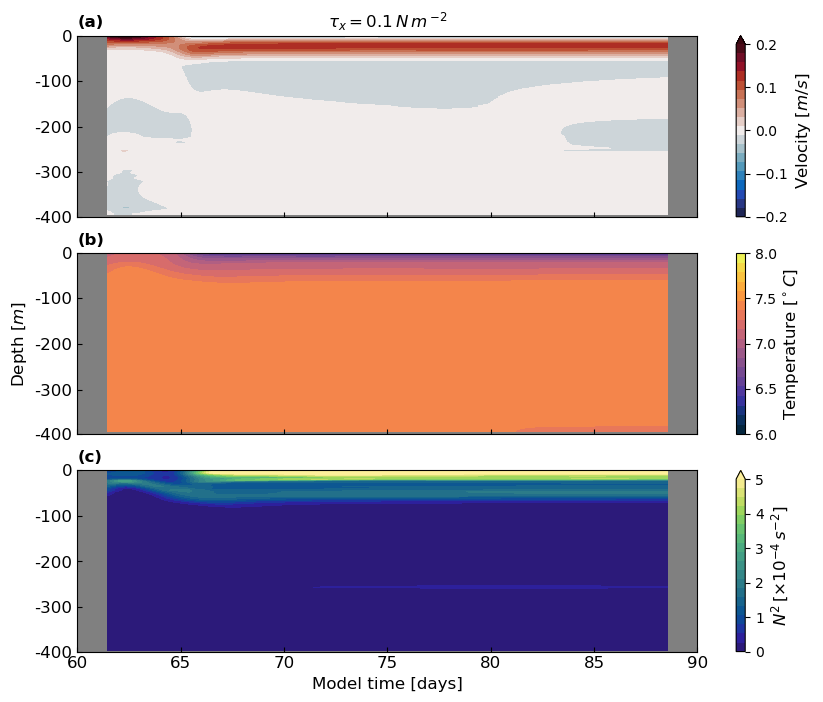

In [87]:
model_day = time / 86400
fig2, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(10,8))

U1, Temp1, Sal1, Nsq1 = u[:,:,xng], temp[:,:,xng], sal[:,:,xng], Nsq
mask = (Sal1 == 0)
U1[mask] = np.nan

cr_u = np.linspace(-0.2,0.2,20) # Contour range
cr_t = np.linspace(6,8,20)
cr_s = np.linspace(26,32,20)
cN = np.linspace(0,5,20) # Contour range for N2

# Along-fjord velocity
im1 = ax1.contourf(model_day, depth, fun.filt_godin_mat(U1).T, cr_u, cmap=cmocean.cm.balance,extend='max') 

cbar1 = fig2.colorbar(im1,ax=ax1)
#cbar1.set_ticks([-0.1,-0.05,0,0.05,0.1])
cbar1.set_ticks([-0.2, -0.1,0,0.1,0.2])
cbar1.set_label('Velocity [$m/s$]', size=12)

ax1.set_facecolor('grey')
ax1.tick_params(direction='in', labelsize=12)
#ax1.xaxis.set_visible(False)
#ax1.set_xlim([dist[0],40])
# ax1.set_xticks([X[0], 10, 20, 30, X[-1]])
ax1.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax1.set_yticklabels(["0","-100","-200","-300","-400"])
#ax1.set_ylabel('Depth [$m$]', size=15)
ax1.set_title(r'(a)', loc='left', size=12, weight='bold')
ax1.set_title(r'$\tau_x=0.1\,N\,m\,^{-2}$', loc='center', size=12, weight='bold')

# Potential temperature
im2 = ax2.contourf(model_day, depth, fun.filt_godin_mat(Temp1).T, cr_t, cmap=cmocean.cm.thermal) 

cbar2 = fig2.colorbar(im2,ax=ax2)
cbar2.set_ticks([6,6.5,7,7.5,8])
cbar2.set_label('Temperature [$^\circ C$]', size=12)

ax2.set_facecolor('grey')
ax2.tick_params(direction='in', labelsize=12)
#ax2.set_xlim([dist[0],40])
#ax2.set_xticks([X[0], 10, 20, 30, X[-1]])
ax2.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax2.set_yticklabels(["0","-100","-200","-300","-400"])
ax2.set_ylabel('Depth [$m$]', size=12)
ax2.set_title(r'(b)', loc='left', size=12, weight='bold')



# # Salinity
# im3 = ax3.contourf(model_day, depth, fun.filt_godin_mat(Sal1).T, cr_s, cmap=cmocean.cm.haline)

# cbar3 = fig2.colorbar(im3,ax=ax3)
# cbar3.set_ticks([26,28,30,32])
# cbar3.set_label('Salinity', size=15)

# Stratification
im3 = ax3.contourf(model_day, (depth[:-1] + depth[1:]) / 2, 1e4*fun.filt_godin_mat(Nsq1).T, cN, cmap=cmocean.cm.haline, extend='max')

cbar3 = fig2.colorbar(im3,ax=ax3)
# cbar3.set_ticks([26,28,30,32])
# cbar3.set_label('Salinity', size=15)
cbar3.set_ticks([0,1,2,3,4,5])
cbar3.set_label(r'$N^2\,[\times 10^{-4}\,s^{-2}]$', size=12)

ax3.set_facecolor('grey')
ax3.tick_params(direction='in', labelsize=12)
ax3.set_yticks([depth[0], -100, -200, -300, depth[-1]])
ax3.set_yticklabels(["0","-100","-200","-300","-400"])
#ax3.set_ylabel('Depth [$m$]', size=15)
ax3.set_title(r'(c)', loc='left', size=12, weight='bold')
#ax3.set_xlim([dist[0],40])
#ax3.set_xticks([X[0], 10, 20, 30, X[-1]])
#ax3.set_xticklabels(["0","10","20","30","40"])
ax3.set_xlabel('Model time [days]', size=12)

fig2.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/near-glacier_wind04.png', dpi=300, bbox_inches='tight')